In [29]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [30]:
AUDIO_DIR = "../valid_data/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "metadata_compiled_valid.parquet.gzip")

# Use pandas to read the parquet file with uncorrupted audio files

The uncorrupted files are removed using bad_file_remover.ipynb

In [4]:
AUDIO_DIR = "../valid_data/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "metadata_compiled_valid_edited.parquet.gzip")

In [5]:
df = pd.read_parquet(ANNOTATIONS_FILE)

# Creating a more even distribution of healthy v. covid samples

Creating a csv file with only 700 healthy and 700 covid samples

In [ ]:
#for each entry in df, find the status of the file
print(df)
healthy = 0
covid = 0
for index, row in df.iterrows():
    if os.path.isfile(os.path.join(AUDIO_DIR, row['uuid'] + '.wav')):
        if row['status'] == 'healthy':
            if row['cough_detected'] > 0.98:
                if healthy < 700:
                    healthy += 1
                else:
                    #remove the row from the dataframe
                    df.drop(index, inplace=True)
            else:
                #remove the row from the dataframe
                df.drop(index, inplace=True)
        elif row['status'] == 'symptomatic':
            df.drop(index, inplace=True)
        else:
            covid += 1
#save the dataframe
df.to_csv(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_700.csv"))
df.to_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_700.parquet.gzip"))
print('healthy: ', healthy)
print('covid: ', covid)

Creating the train, test, val dataset

In [ ]:
df_bal = pd.read_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_700.parquet.gzip"))
print(df_bal)

train_val_b, test_b = train_test_split(df_bal, test_size=0.1, random_state=0, stratify=df_bal[['status']])
train_b, val_b = train_test_split(train_val_b, test_size=0.1, random_state=0, stratify=train_val_b[['status']])

train_b = train_b.reset_index(drop=True)
val_b = val_b.reset_index(drop=True)
test_b = test_b.reset_index(drop=True)

train_b.to_parquet("train_balanced_700.parquet.gzip")
val_b.to_parquet("val_balanced_700.parquet.gzip")
test_b.to_parquet("test_balanced_700.parquet.gzip")

print(train_b)
print(val_b)

# train_b.to_csv("train_balanced.csv")
# val_b.to_csv("val_balanced.csv")
# test_b.to_csv("test_balanced.csv")

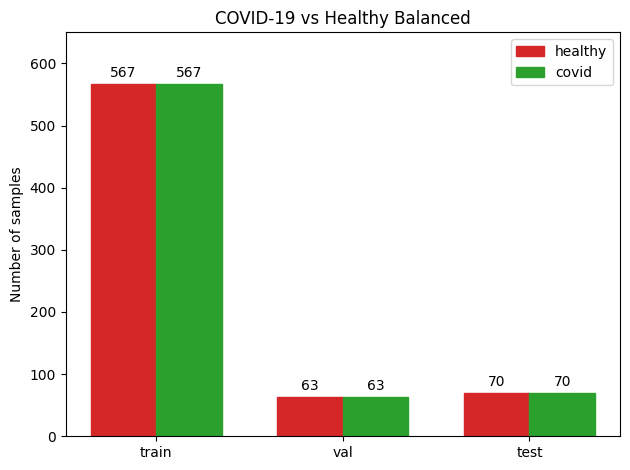

<Figure size 640x480 with 0 Axes>

In [47]:
#build a bar plot of the number of healthy and covid samples in each set
AUDIO_DIR = "../valid_data/"

healthy_train = 0
covid_train = 0
healthy_val = 0
covid_val = 0
healthy_test = 0
covid_test = 0

train_b = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced_700.parquet.gzip"))
val_b = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced_700.parquet.gzip"))
test_b = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced_700.parquet.gzip"))

for index, row in train_b.iterrows():
    if row['status'] == 'healthy':
        healthy_train += 1
    else:
        covid_train += 1
for index, row in val_b.iterrows():
    if row['status'] == 'healthy':
        healthy_val += 1
    else:
        covid_val += 1
for index, row in test_b.iterrows():
    if row['status'] == 'healthy':
        healthy_test += 1
    else:
        covid_test += 1

#use this to plot the bar graph
healthy = [healthy_train, healthy_val, healthy_test]
covid = [covid_train, covid_val, covid_test]
labels = ['train', 'val', 'test']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy, width, label='healthy')
rects2 = ax.bar(x + width/2, covid, width, label='covid')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('COVID-19 vs Healthy Balanced')
# add labels on top of the bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
# change the color of the bars
rects1[0].set_color('tab:red')
rects1[1].set_color('tab:red')
rects1[2].set_color('tab:red')
rects2[0].set_color('tab:green')
rects2[1].set_color('tab:green')
rects2[2].set_color('tab:green')
# add buffer to the y axis
ax.set_ylim(top=650)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show() 
plt.savefig('balanced_700.png')

# Creating segmented audio dataset

In [16]:
import sys
import torch
import torchaudio
sys.path.insert(0, '../src')
from segmentation import segment_cough

NEW_DIR = "../balanced_segmented_data/"

if not os.path.exists(NEW_DIR):
   os.makedirs(NEW_DIR)

df = pd.read_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_700.parquet.gzip"))

#create a copy of df
df_seg = df.copy()

#for each entry in df, load and segment the audio file
for index, row in df.iterrows():
    if os.path.isfile(os.path.join(AUDIO_DIR, row['uuid'] + '.wav')):
        path = os.path.join(AUDIO_DIR, row['uuid'] + ".wav")
        signal, sr = torchaudio.load(path)
        segments, segmented_mask = segment_cough(signal.numpy()[0], sr)
        if len(segments) > 0:
            signal = torch.tensor(segments[0])
            signal = signal.unsqueeze(0)
            torchaudio.save(os.path.join(NEW_DIR, row['uuid'])+"_segmented.wav", signal, sr)
        else:
            signal = signal
            # write the unsegmented files to a file called unsegmented
            with open(os.path.join(NEW_DIR, "unsegmented.csv"), "a") as f:
                f.write(row['uuid'] + "_unsegmented.wav \n")
            # remove the row from the dataframe
            df_seg.drop(index, inplace=True)
            torchaudio.save(os.path.join(NEW_DIR, row['uuid'])+"_unsegmented.wav", signal, sr)        

df_seg.to_parquet(os.path.join(NEW_DIR, "metadata_compiled_valid_balanced_700_segmented.parquet.gzip"))
        

In [ ]:
df_seg = pd.read_parquet(os.path.join(NEW_DIR, "metadata_compiled_valid_balanced_700_segmented.parquet.gzip"))
#print status = healthy number in the dataframe
print('healthy: ', df_seg[df_seg['status'] == 'healthy'].count())
#print status = covid number in the dataframe
print('covid: ', df_seg[df_seg['status'] == 'COVID-19'].count())

train_val_s, test_s = train_test_split(df_seg, test_size=0.1, random_state=0, stratify=df_seg[['status']])
train_s, val_s = train_test_split(train_val_s, test_size=0.1, random_state=0, stratify=train_val_s[['status']])

train_s = train_s.reset_index(drop=True)
val_s = val_s.reset_index(drop=True)
test_s = test_s.reset_index(drop=True)

train_s.to_parquet("train_balanced_700_segmented.parquet.gzip")
val_s.to_parquet("val_balanced_700_segmented.parquet.gzip")
test_s.to_parquet("test_balanced_700_segmented.parquet.gzip")



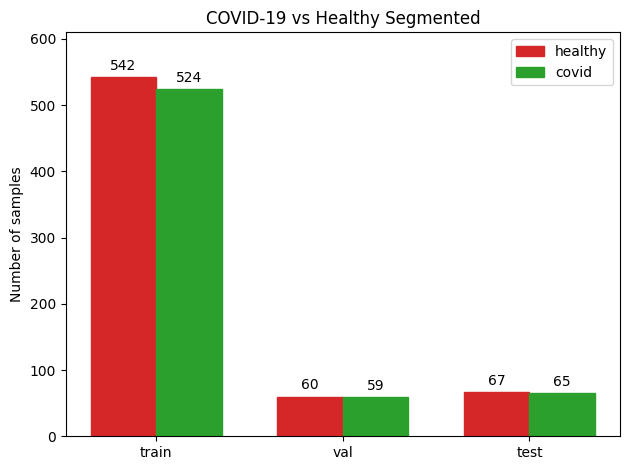

<Figure size 640x480 with 0 Axes>

In [50]:
#build a bar plot of the number of healthy and covid samples in each set
AUDIO_DIR = "../balanced_segmented_data/"

healthy_train = 0
covid_train = 0
healthy_val = 0
covid_val = 0
healthy_test = 0
covid_test = 0

train_b = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced_700_segmented.parquet.gzip"))
val_b = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced_700_segmented.parquet.gzip"))
test_b = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced_700_segmented.parquet.gzip"))

for index, row in train_b.iterrows():
    if row['status'] == 'healthy':
        healthy_train += 1
    else:
        covid_train += 1
for index, row in val_b.iterrows():
    if row['status'] == 'healthy':
        healthy_val += 1
    else:
        covid_val += 1
for index, row in test_b.iterrows():
    if row['status'] == 'healthy':
        healthy_test += 1
    else:
        covid_test += 1

#use this to plot the bar graph
healthy = [healthy_train, healthy_val, healthy_test]
covid = [covid_train, covid_val, covid_test]
labels = ['train', 'val', 'test']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy, width, label='healthy')
rects2 = ax.bar(x + width/2, covid, width, label='covid')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('COVID-19 vs Healthy Segmented')
# add labels on top of the bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
# change the color of the bars
rects1[0].set_color('tab:red')
rects1[1].set_color('tab:red')
rects1[2].set_color('tab:red')
rects2[0].set_color('tab:green')
rects2[1].set_color('tab:green')
rects2[2].set_color('tab:green')
# add buffer to the y axis
ax.set_ylim(top=610)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show() 
plt.savefig('balanced_700_segmented.png')

# Create Oversampled 3,500 Covid / 3,500 Healthy Dataset

In [80]:
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "metadata_compiled_valid_edited.parquet.gzip")
df = pd.read_parquet(ANNOTATIONS_FILE)

train_val, test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['status'])
train, val = train_test_split(train_val, test_size=0.1, random_state=0, stratify=train_val['status'])


# for val and test make sure no status = symptomatic gets in
val = val[val['status'] != 'symptomatic']
test = test[test['status'] != 'symptomatic']


val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

test.to_parquet("test_balanced_3500.parquet.gzip")
test.to_csv("test_balanced_3500.csv")
val.to_parquet("val_balanced_3500.parquet.gzip")


# for the test set, we want to make sure that we have 50% healthy and 50% covid
df = train
df2 = pd.DataFrame(columns=df.columns)

covid = 0
healthy = 0

for index, row in df.iterrows():
    if os.path.isfile(os.path.join(AUDIO_DIR, row['uuid'] + '.wav')):
        if row['status'] == 'healthy':
            if row['cough_detected'] > 0.98:
                if healthy < 3500:
                    healthy += 1
                    df2 = df2.append(row, ignore_index=True)
        elif row['status'] == 'COVID-19':
            # add the row 4 times in random locations to the dataframe
            for i in range(5):
                df2 = df2.append(row, ignore_index=True)
                covid += 1


df2 = df2.sample(frac=1).reset_index(drop=True)
df2.to_parquet("train_balanced_3500.parquet.gzip")
#save as csv
df2.to_csv("train_balanced_3500.csv")

print('healthy: ', healthy)
print('covid: ', covid)


/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/3633458505.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/3633458505.py:34: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/3633458505.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/3633458505.py:38: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in re

healthy:  3462
covid:  2835


In [81]:
# read in the parquet test and val files
test = pd.read_parquet("test_balanced_3500.parquet.gzip")
# create a csv file for the test set
test.to_csv("test_balanced_3500.csv")

val = pd.read_parquet("val_balanced_3500.parquet.gzip")
# create a csv file for the val set
val.to_csv("val_balanced_3500.csv")

train = pd.read_parquet("train_balanced_3500.parquet.gzip")

#print test and val
print('test: ', test)
print('val: ', val)
print('train: ', train)

test:                                        uuid                          datetime  \
0     5574d83f-0eb9-459a-ae08-123d25564976  2020-09-17T20:48:05.087147+00:00   
1     50cc7a81-f59d-4bae-8baa-bbd6314a66f2  2020-07-20T14:33:29.438335+00:00   
2     1579b93d-0ee3-4484-975c-a8777c0b6739  2020-07-28T16:31:31.397647+00:00   
3     09ef22ac-58b8-4f3b-b00a-94f926298dae  2020-04-15T11:04:16.563597+00:00   
4     83db8a5d-1b49-4ac3-9ff2-72428fcf1ee8  2020-10-20T09:47:04.210664+00:00   
...                                    ...                               ...   
1031  a0ffec92-b366-4251-bcc0-87e7f465b6e2  2020-04-19T08:48:25.442654+00:00   
1032  28854707-b408-4b25-ace4-0797baff5f85  2020-11-17T15:42:12.570624+00:00   
1033  3f9c965a-cc4e-4b49-b9b4-af47e8f962ce  2020-06-15T03:03:18.209230+00:00   
1034  1f0150f1-2882-4978-82cf-7786e0346f2e  2021-03-18T10:49:30.504277+00:00   
1035  9d4c8a19-2b4f-4ce6-ac2c-4df88eace1d1  2020-04-13T20:02:06.545516+00:00   

      cough_detected  latitude  

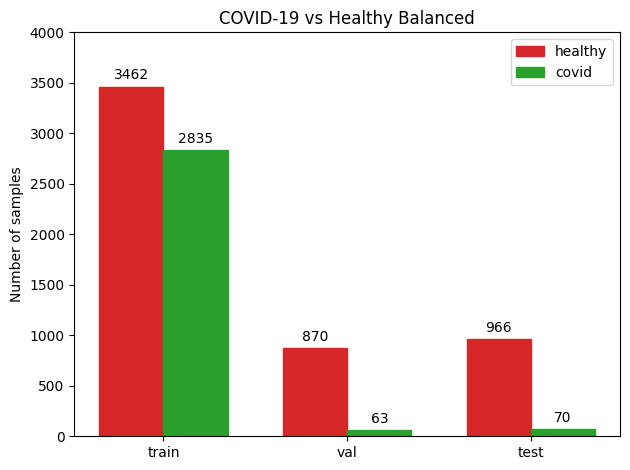

<Figure size 640x480 with 0 Axes>

In [82]:
# build graph of train, val, test dataset to show how many healthy and covid samples are in each set

healthy_train = 0
covid_train = 0
healthy_val = 0
covid_val = 0
healthy_test = 0
covid_test = 0

train_b = pd.read_parquet("train_balanced_3500.parquet.gzip")
val_b = pd.read_parquet("val_balanced_3500.parquet.gzip")
test_b = pd.read_parquet("test_balanced_3500.parquet.gzip")

for index, row in train_b.iterrows():
    if row['status'] == 'healthy':
        healthy_train += 1
    else:
        covid_train += 1
for index, row in val_b.iterrows():
    if row['status'] == 'healthy':
        healthy_val += 1
    else:
        covid_val += 1
for index, row in test_b.iterrows():
    if row['status'] == 'healthy':
        healthy_test += 1
    else:
        covid_test += 1

#use this to plot the bar graph
healthy = [healthy_train, healthy_val, healthy_test]
covid = [covid_train, covid_val, covid_test]
labels = ['train', 'val', 'test']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy, width, label='healthy')
rects2 = ax.bar(x + width/2, covid, width, label='covid')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('COVID-19 vs Healthy Balanced')
# add labels on top of the bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
# change the color of the bars
rects1[0].set_color('tab:red')
rects1[1].set_color('tab:red')
rects1[2].set_color('tab:red')
rects2[0].set_color('tab:green')
rects2[1].set_color('tab:green')
rects2[2].set_color('tab:green')
# add buffer to the y axis
ax.set_ylim(top=4000)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()
plt.savefig('balanced_3500.png')



In [57]:
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "metadata_compiled_valid_edited.parquet.gzip")
df = pd.read_parquet(ANNOTATIONS_FILE)

# create a new dataframe called df2 with all the same columns as df
df2 = pd.DataFrame(columns=df.columns)

#for each entry in df, find the status of the file
healthy = 0
covid = 0
for index, row in df.iterrows():
    if os.path.isfile(os.path.join(AUDIO_DIR, row['uuid'] + '.wav')):
        if row['status'] == 'healthy':
            if row['cough_detected'] > 0.98:
                if healthy < 3500:
                    healthy += 1
                    df2 = df2.append(row, ignore_index=True)
        elif row['status'] == 'COVID-19':
            # add the row 4 times in random locations to the dataframe
            for i in range(5):
                df2 = df2.append(row, ignore_index=True)
                covid += 1
#save the dataframe

df2.to_csv(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_3500.csv"))
df2.to_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_3500.parquet.gzip"))
print('healthy: ', healthy)
print('covid: ', covid)

/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/4076130440.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/4076130440.py:16: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/4076130440.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/ny/vqpkp9312bd00t4tc56rd7d00000gn/T/ipykernel_6220/4076130440.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in re

KeyboardInterrupt: 

In [ ]:
df_3500 = pd.read_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid_balanced_3500.parquet.gzip"))
#print status = healthy number in the dataframe
print('healthy: ', df_3500[df_3500['status'] == 'healthy'].count())
#print status = covid number in the dataframe
print('covid: ', df_3500[df_3500['status'] == 'COVID-19'].count())

train_val_3500, test_3500 = train_test_split(df_3500, test_size=0.1, random_state=0, stratify=df_3500[['status']])
train_3500, val_3500 = train_test_split(train_val_3500, test_size=0.1, random_state=0, stratify=train_val_3500[['status']])

train_3500 = train_3500.reset_index(drop=True)
val_s = val_3500.reset_index(drop=True)
test_s = test_3500.reset_index(drop=True)

train_3500.to_parquet("train_balanced_3500.parquet.gzip")
val_3500.to_parquet("val_balanced_3500.parquet.gzip")
test_3500.to_parquet("test_balanced_3500.parquet.gzip")

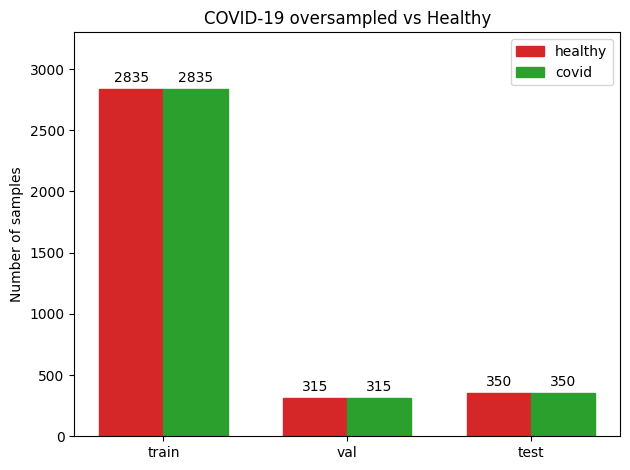

<Figure size 640x480 with 0 Axes>

In [51]:
#build a bar plot of the number of healthy and covid samples in each set
AUDIO_DIR = "../valid_data/"

healthy_train = 0
covid_train = 0
healthy_val = 0
covid_val = 0
healthy_test = 0
covid_test = 0

train_b = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced_3500.parquet.gzip"))
val_b = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced_3500.parquet.gzip"))
test_b = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced_3500.parquet.gzip"))

for index, row in train_b.iterrows():
    if row['status'] == 'healthy':
        healthy_train += 1
    else:
        covid_train += 1
for index, row in val_b.iterrows():
    if row['status'] == 'healthy':
        healthy_val += 1
    else:
        covid_val += 1
for index, row in test_b.iterrows():
    if row['status'] == 'healthy':
        healthy_test += 1
    else:
        covid_test += 1

#use this to plot the bar graph
healthy = [healthy_train, healthy_val, healthy_test]
covid = [covid_train, covid_val, covid_test]
labels = ['train', 'val', 'test']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy, width, label='healthy')
rects2 = ax.bar(x + width/2, covid, width, label='covid')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('COVID-19 oversampled vs Healthy')
# add labels on top of the bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
# change the color of the bars
rects1[0].set_color('tab:red')
rects1[1].set_color('tab:red')
rects1[2].set_color('tab:red')
rects2[0].set_color('tab:green')
rects2[1].set_color('tab:green')
rects2[2].set_color('tab:green')
# add a little buffer to the y axis
ax.set_ylim(top=3300)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show() 
plt.savefig('balanced_3500.png')

# Create the original dataset

In [52]:
train_val, test = train_test_split(df, test_size=0.1, random_state=0, stratify=df[['status']])
train, val = train_test_split(train_val, test_size=0.1, random_state=0, stratify=train_val[['status']])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [11]:
train.to_parquet("train_edited.parquet.gzip")
val.to_parquet("val_edited.parquet.gzip")
test.to_parquet("test_edited.parquet.gzip")

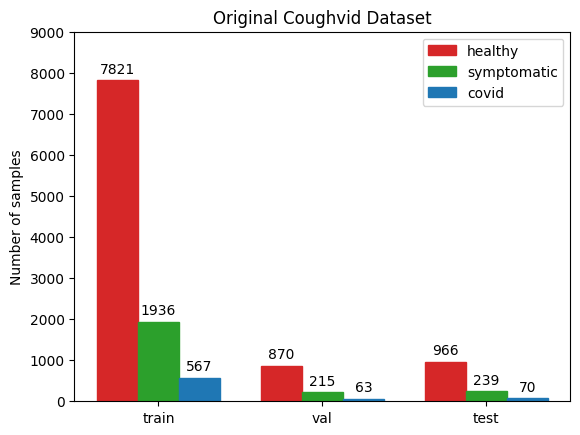

In [91]:
# graph the number of healthy, covid, and symptomatic samples in each set
AUDIO_DIR = "../valid_data/"

healthy_train = 0
symptomatic_train = 0
covid_train = 0
healthy_val = 0
symptomatic_val = 0
covid_val = 0
healthy_test = 0
symptomatic_test = 0
covid_test = 0

train = pd.read_parquet(os.path.join(AUDIO_DIR, "train_edited.parquet.gzip"))
val = pd.read_parquet(os.path.join(AUDIO_DIR, "val_edited.parquet.gzip"))
test = pd.read_parquet(os.path.join(AUDIO_DIR, "test_edited.parquet.gzip"))

for index, row in train.iterrows():
    if row['status'] == 'healthy':
        healthy_train += 1
    elif row['status'] == 'symptomatic':
        symptomatic_train += 1
    else:
        covid_train += 1
for index, row in val.iterrows():
    if row['status'] == 'healthy':
        healthy_val += 1
    elif row['status'] == 'symptomatic':
        symptomatic_val += 1
    else:
        covid_val += 1
for index, row in test.iterrows():
    if row['status'] == 'healthy':
        healthy_test += 1
    elif row['status'] == 'symptomatic':
        symptomatic_test += 1
    else:
        covid_test += 1

#use this to plot the bar graph
healthy = [healthy_train, healthy_val, healthy_test]
symptomatic = [symptomatic_train, symptomatic_val, symptomatic_test]
covid = [covid_train, covid_val, covid_test]
labels = ['train', 'val', 'test']
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
#plot the bar graph
fig, ax = plt.subplots()
#divide into 3 groups
rects1 = ax.bar(x - width, healthy, width, label='healthy')
rects2 = ax.bar(x, symptomatic, width, label='symptomatic')
rects3 = ax.bar(x + width, covid, width, label='covid')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('Original Coughvid Dataset')
# add labels on top of the bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects3:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
# change the color of the bars
rects1[0].set_color('tab:red')
rects1[1].set_color('tab:red')
rects1[2].set_color('tab:red')
rects2[0].set_color('tab:green')
rects2[1].set_color('tab:green')
rects2[2].set_color('tab:green')
rects3[0].set_color('tab:blue')
rects3[1].set_color('tab:blue')
rects3[2].set_color('tab:blue')
# add a little buffer to the y axis

# add spacing between train, val, and test on the x axis
ax.set_ylim(top=9000)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()


In [55]:
AUDIO_DIR = "../valid_data/"
# load the test and val_edited dataframes
test = pd.read_parquet(os.path.join(AUDIO_DIR, "test_edited.parquet.gzip"))
val = pd.read_parquet(os.path.join(AUDIO_DIR, "val_edited.parquet.gzip"))

#for each file in test and val, if status is symptomatic, remove
for index, row in test.iterrows():
    if row['status'] == 'symptomatic':
        test = test.drop(index)
for index, row in val.iterrows():
    if row['status'] == 'symptomatic':
        val = val.drop(index)

#save the new test and val dataframes
test.to_parquet("test_edited_nosymp.parquet.gzip")
val.to_parquet("val_edited_nosymp.parquet.gzip")
